# Imports

In [1]:
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import missingno as msno

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="lbfgs failed to converge*", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="`shade` is now deprecated*", category=FutureWarning)
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated*", category=FutureWarning)
warnings.filterwarnings("ignore", message="`shade` is now deprecated*", category=FutureWarning)

# Reading and Exploring the data

In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
print('train_data rows: ',train_data.shape[0])
print('train_data columns: ',train_data.shape[1])
print()
print('test_data rows: ',test_data.shape[0])
print('test_data columns: ',test_data.shape[1])

train_data rows:  1460
train_data columns:  81

test_data rows:  1459
test_data columns:  80


**Distribution of class label**

/tmp/ipykernel_18/1345581988.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_data['SalePrice'], shade=True, color='skyblue')


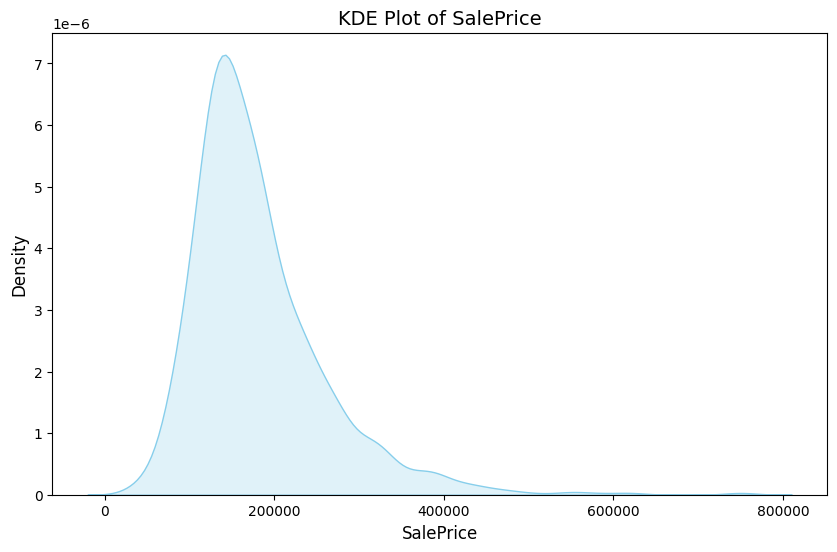

In [5]:
plt.figure(figsize=(10, 6))

sns.kdeplot(train_data['SalePrice'], shade=True, color='skyblue')

plt.xlabel('SalePrice', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('KDE Plot of SalePrice', fontsize=14)

plt.show()

as simply in rea life, most prices are similar making a peak near 200k. some houses will have way higher prices as shown, the kde plot continous to more than 800k.

Checking the number of unqiue values per feature

In [6]:
unique_values = train_data.nunique().reset_index()
unique_values.columns = ['Feature', 'Unique_Values']

unique_values_sorted = unique_values.sort_values(by='Unique_Values', ascending=False)

# pd.set_option('display.max_rows', None)

unique_values_sorted

,Feature,Unique_Values
0,Id,1460
4,LotArea,1073
46,GrLivArea,861
37,BsmtUnfSF,780
43,1stFlrSF,753
...,...,...
50,HalfBath,3
5,Street,2
41,CentralAir,2
9,Utilities,2


Applying the same for test_data

In [7]:
unique_values = test_data.nunique().reset_index()
unique_values.columns = ['Feature', 'Unique_Values']

unique_values_sorted = unique_values.sort_values(by='Unique_Values', ascending=False)

unique_values_sorted

,Feature,Unique_Values
0,Id,1459
4,LotArea,1106
46,GrLivArea,879
37,BsmtUnfSF,793
43,1stFlrSF,789
...,...,...
72,PoolQC,2
6,Alley,2
5,Street,2
41,CentralAir,2


Checking if there are any **duplicate columns** since we have many features.

In [8]:
duplicate_columns_train = train_data.columns[train_data.columns.duplicated()].tolist()

if not duplicate_columns_train:
    print("No duplicate columns found in train_data.")
else:
    train_data = train_data.drop(columns=duplicate_columns_train)
    print("Duplicate columns in train_data:", duplicate_columns_train)

No duplicate columns found in train_data.


Checking for test_data

In [9]:
duplicate_columns_test = test_data.columns[test_data.columns.duplicated()].tolist()

if not duplicate_columns_test:
    print("No duplicate columns found in test_data.")
else:
    test_data = test_data.drop(columns=duplicate_columns_test)
    print("Duplicate columns in test_data:", duplicate_columns_test)

No duplicate columns found in test_data.


Sorting features by their **data type**

In [10]:
feature_data_types = pd.DataFrame(train_data.dtypes).reset_index()
feature_data_types.columns = ['Feature', 'Data Type']

grouped_features = feature_data_types.groupby('Data Type')['Feature'].apply(list).reset_index()

grouped_features_sorted = grouped_features.sort_values(by='Data Type')

print("Features sorted by Data Type:")
for index, row in grouped_features_sorted.iterrows():
    print(row['Data Type'])
    for feature in sorted(row['Feature']):
        print("  -", feature)

Features sorted by Data Type:
int64
  - 1stFlrSF
  - 2ndFlrSF
  - 3SsnPorch
  - BedroomAbvGr
  - BsmtFinSF1
  - BsmtFinSF2
  - BsmtFullBath
  - BsmtHalfBath
  - BsmtUnfSF
  - EnclosedPorch
  - Fireplaces
  - FullBath
  - GarageArea
  - GarageCars
  - GrLivArea
  - HalfBath
  - Id
  - KitchenAbvGr
  - LotArea
  - LowQualFinSF
  - MSSubClass
  - MiscVal
  - MoSold
  - OpenPorchSF
  - OverallCond
  - OverallQual
  - PoolArea
  - SalePrice
  - ScreenPorch
  - TotRmsAbvGrd
  - TotalBsmtSF
  - WoodDeckSF
  - YearBuilt
  - YearRemodAdd
  - YrSold
float64
  - GarageYrBlt
  - LotFrontage
  - MasVnrArea
object
  - Alley
  - BldgType
  - BsmtCond
  - BsmtExposure
  - BsmtFinType1
  - BsmtFinType2
  - BsmtQual
  - CentralAir
  - Condition1
  - Condition2
  - Electrical
  - ExterCond
  - ExterQual
  - Exterior1st
  - Exterior2nd
  - Fence
  - FireplaceQu
  - Foundation
  - Functional
  - GarageCond
  - GarageFinish
  - GarageQual
  - GarageType
  - Heating
  - HeatingQC
  - HouseStyle
  - KitchenQu

💡 Few float features and seemingly equal number of integer features and categorical.

# Handling missing values

Checking the numbre of columnms with **missing values**

In [11]:
train_missing_values = train_data.isnull().sum()
num_columns_with_train_missing_values = (train_missing_values > 0).sum()
print(f'Total number of columns with missing values: {num_columns_with_train_missing_values}')

Total number of columns with missing values: 19


Applying the same for test_data

In [12]:
test_missing_values = test_data.isnull().sum()
num_columns_with_test_missing_values = (test_missing_values > 0).sum()
print(f'Total number of columns with missing values: {num_columns_with_test_missing_values}')

Total number of columns with missing values: 33


## Do we drop features with missing values?
A decision as such needs to consider the precentrage of missing values, some blogs mentioned keeping columns with missing values & below 30, some other said 50%.



When approaching the pre-processing step of handling missing values, various techniques can be employed, ranging from simple methods such as 
filling with the **mode**, **mean**, or **median** to more sophisticated techniques like **KNN** and using **machine learning models to impute missing values**.

To make an informed choice among these techniques, it is advisable to **conduct thorough statistical analyses, both visually and computationally**. 

**Visualization methods, such as plotting**, can be employed to assess the distribution of missing values across all columns.

This helps to determine **whether the missing values follow a pattern or occur randomly**. This visual inspection aids in selecting appropriate imputation strategies based on the observed patterns in the data.

----

Let's look at the % of missing values of each column in the data


In [13]:
missing_percentage = (train_missing_values / len(train_data)) * 100

missing_info = pd.DataFrame({
     'Column Name': train_data.columns,
    'Missing Percentage': missing_percentage
})

missing_info_filtered = missing_info[missing_info['Missing Percentage'] != 0]

missing_info_sorted = missing_info_filtered.sort_values(by='Missing Percentage', ascending=False)

missing_info_sorted

,Column Name,Missing Percentage
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
MasVnrType,MasVnrType,59.726027
FireplaceQu,FireplaceQu,47.260274
LotFrontage,LotFrontage,17.739726
GarageType,GarageType,5.547945
GarageYrBlt,GarageYrBlt,5.547945
GarageFinish,GarageFinish,5.547945


In [14]:
missing_percentage = (test_missing_values / len(test_data)) * 100

missing_info = pd.DataFrame({
     'Column Name': test_data.columns,
    'Missing Percentage': missing_percentage
})

missing_info_filtered = missing_info[missing_info['Missing Percentage'] != 0]

missing_info_sorted = missing_info_filtered.sort_values(by='Missing Percentage', ascending=False)

missing_info_sorted

,Column Name,Missing Percentage
PoolQC,PoolQC,99.794380
MiscFeature,MiscFeature,96.504455
Alley,Alley,92.666210
Fence,Fence,80.123372
MasVnrType,MasVnrType,61.274846
FireplaceQu,FireplaceQu,50.034270
LotFrontage,LotFrontage,15.558602
GarageCond,GarageCond,5.346127
GarageYrBlt,GarageYrBlt,5.346127
GarageQual,GarageQual,5.346127


💡 It seems for both train and test data there is a **gap in percentage(%) of missing values**, its less than 20% then more than 45%.. 

❗ Before rushing into dropping any columns, we need to use them first to look at **The Pattern of Missing Data**.

## How to interpret MNSO plot?

Examine the next plot carefully, 

The **blue bars represent each column**. look at the first column from the left, it's a straight blue column with **no white horizontal lines** within. 
This indicates that this feature has **no missing values**.

jump 3 columns and look at the fourth from left, it has several white lines and white spaces, **each line represent one missing value in this of data** across all features. Aside from white lines there are white spaces, these are nothing different, its just **a sequence of missing values**, creating a 'white space'.

From the right, the 7th, 8th and 9th columns are **more white than blue**, these indeed are the columns with very high percentage(%) of missing values as observed in the tabel earlier.

Now we have a general idea of this plot, we will take it a bit further to both clearly read it and be able to draw more accurate decisions and conclusions.

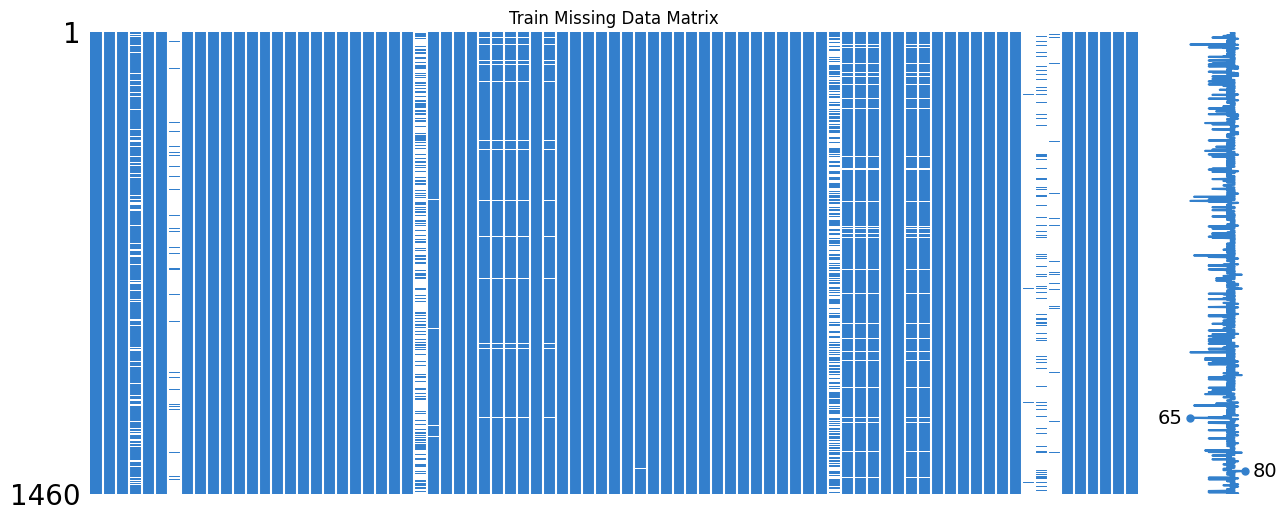

In [15]:
msno.matrix(train_data, figsize=(15, 6), color=(0.2, 0.5, 0.8))
plt.title('Train Missing Data Matrix')
plt.show()

The features with very high percentage(%) of missing values were kept to this point just to explain the mnso plot, we dont need them anymore. 

**🗑️ Any feature with percentage(%) of 40 and more will be dropped**.

In [16]:
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100

features_to_drop = missing_percentage[missing_percentage > 40].index.tolist()

train_data = train_data.drop(features_to_drop, axis=1)

print("Original shape of train_data:", train_data.shape)
print("Shape of train_data after dropping features with missing values above 40%:", train_data.shape)

Original shape of train_data: (1460, 75)
Shape of train_data after dropping features with missing values above 40%: (1460, 75)


🗑️ Dropping for test data

In [17]:
missing_percentage = (test_data.isnull().sum() / len(test_data)) * 100

features_to_drop = missing_percentage[missing_percentage > 40].index.tolist()

test_data = test_data.drop(features_to_drop, axis=1)

print("Original shape of train_data:", test_data.shape)
print("Shape of train_data after dropping features with missing values above 40%:", test_data.shape)

Original shape of train_data: (1459, 74)
Shape of train_data after dropping features with missing values above 40%: (1459, 74)


Same mnso plot, after dropping the previous columns:

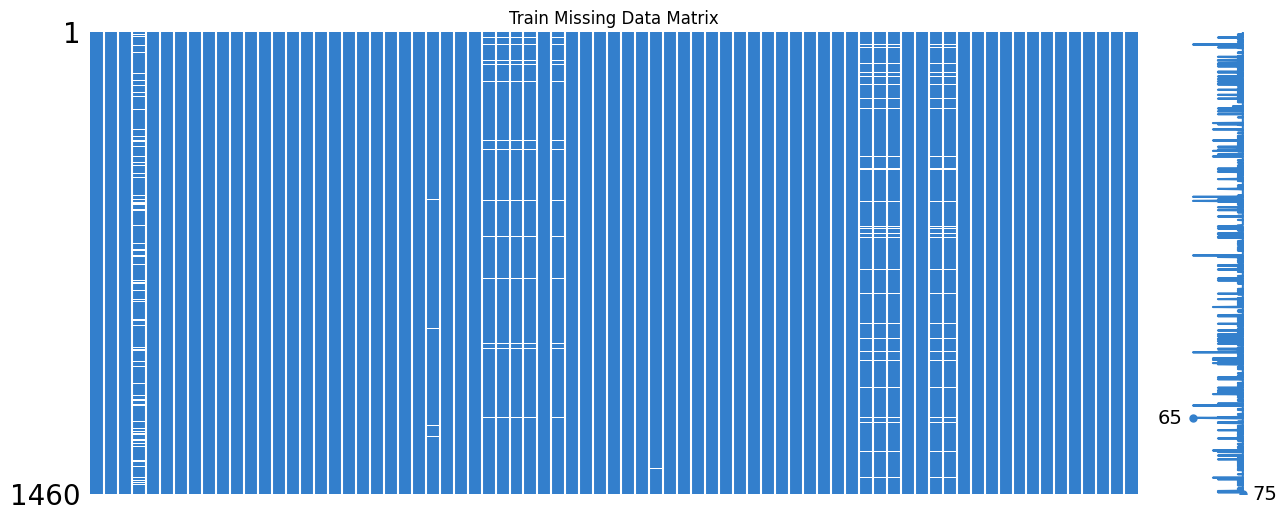

In [18]:
msno.matrix(train_data, figsize=(15, 6), color=(0.2, 0.5, 0.8))
plt.title('Train Missing Data Matrix')
plt.show()

**We seek to find the pattern of missing values** in the data using mnso plot, but i have an idea to make the plot easier to interpret.

Since we have 3 data types of features, lets **plot a msno for each data type. **

In [19]:
categorical_features = train_data.select_dtypes(include=['object'])
int_numeric_features = train_data.select_dtypes(include=['int64'])
float_numeric_features = train_data.select_dtypes(include=['float64'])

#### Int features

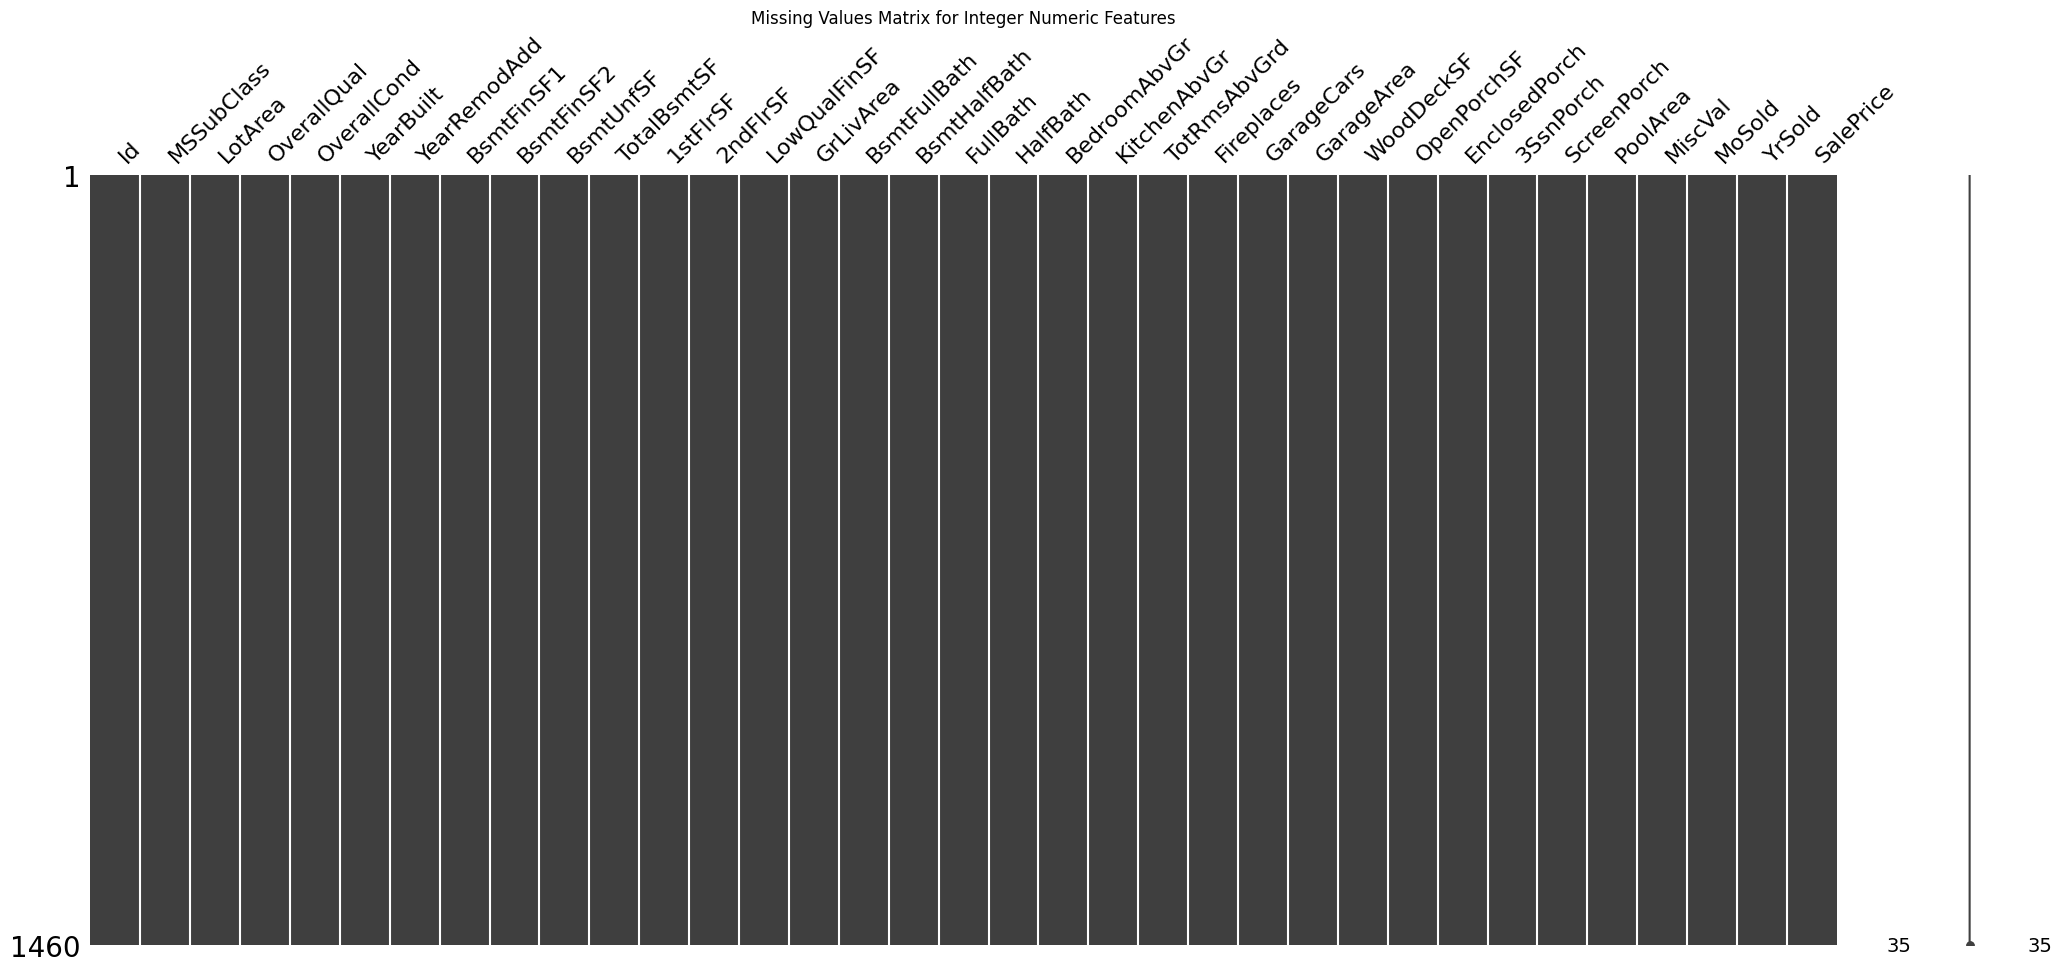

In [20]:
msno.matrix(int_numeric_features)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

💡 Very interesting! int datatypes have no missing values at all.

#### Float features

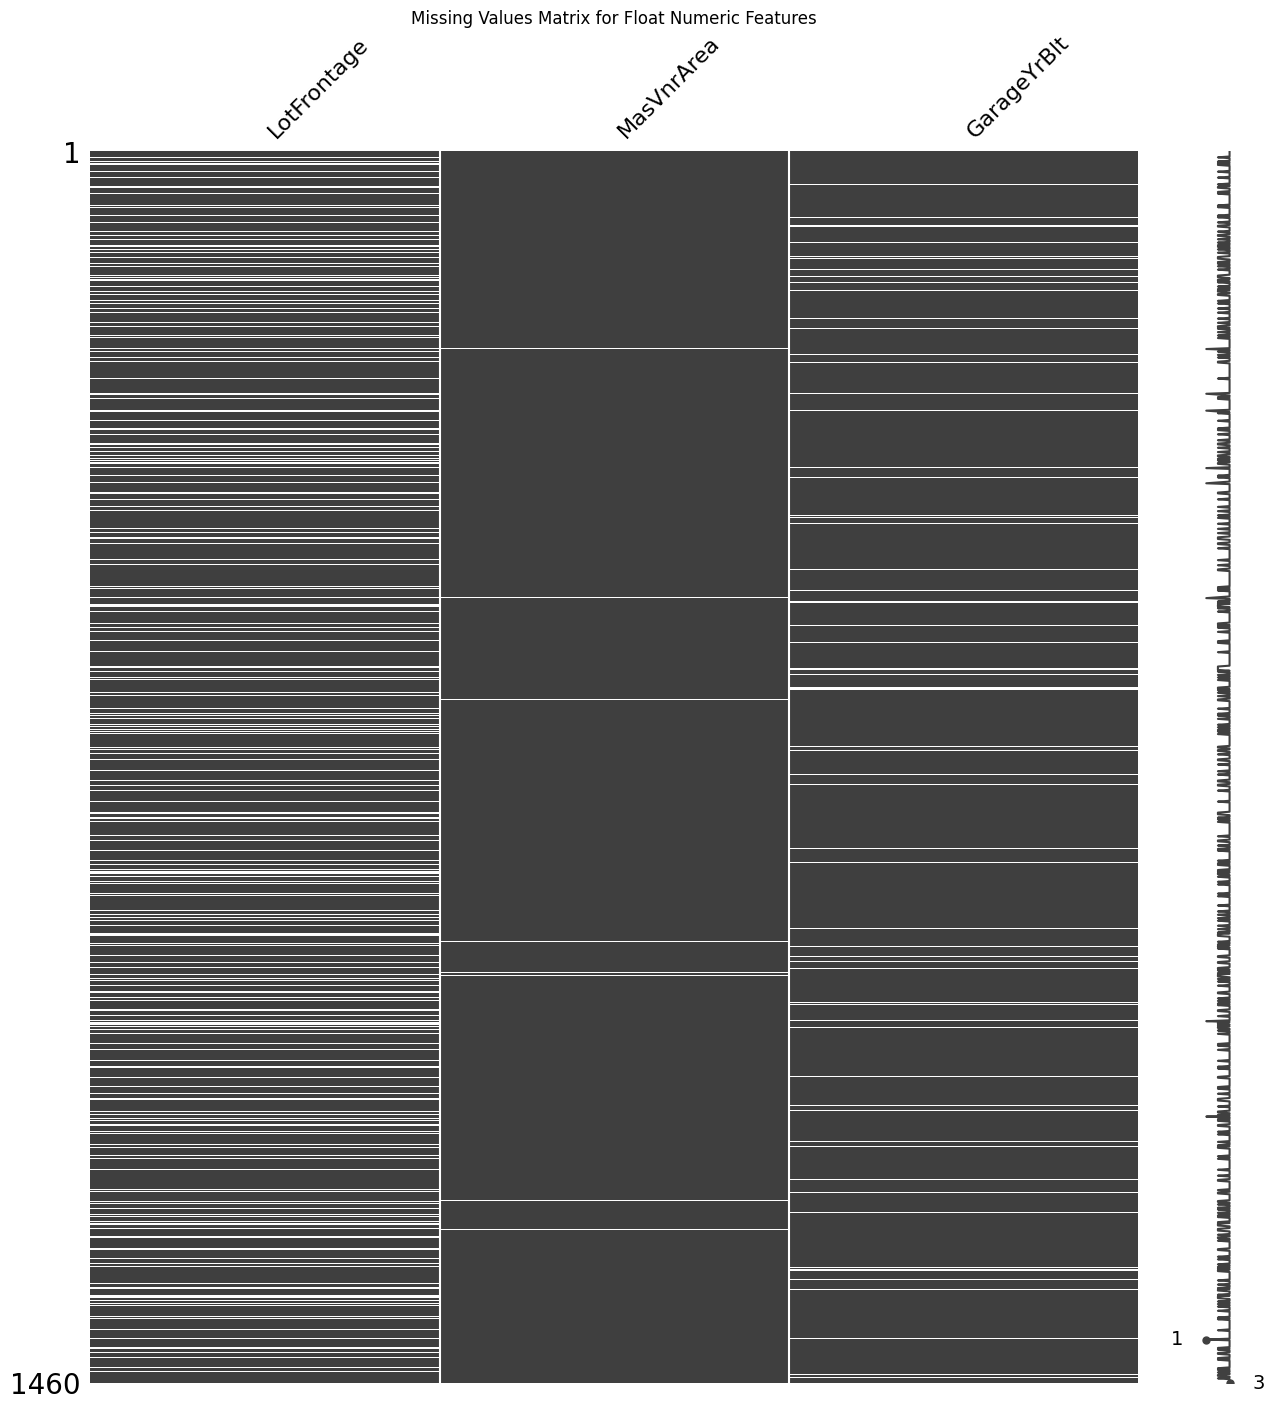

In [21]:
msno.matrix(float_numeric_features, figsize=(15, 16))
plt.title('Missing Values Matrix for Float Numeric Features')
plt.show()

💡 There does not seem to be a pattern in this data, no missing values are mutual as in rows between the 3 float features or at least.. not many.

#### Categorical features

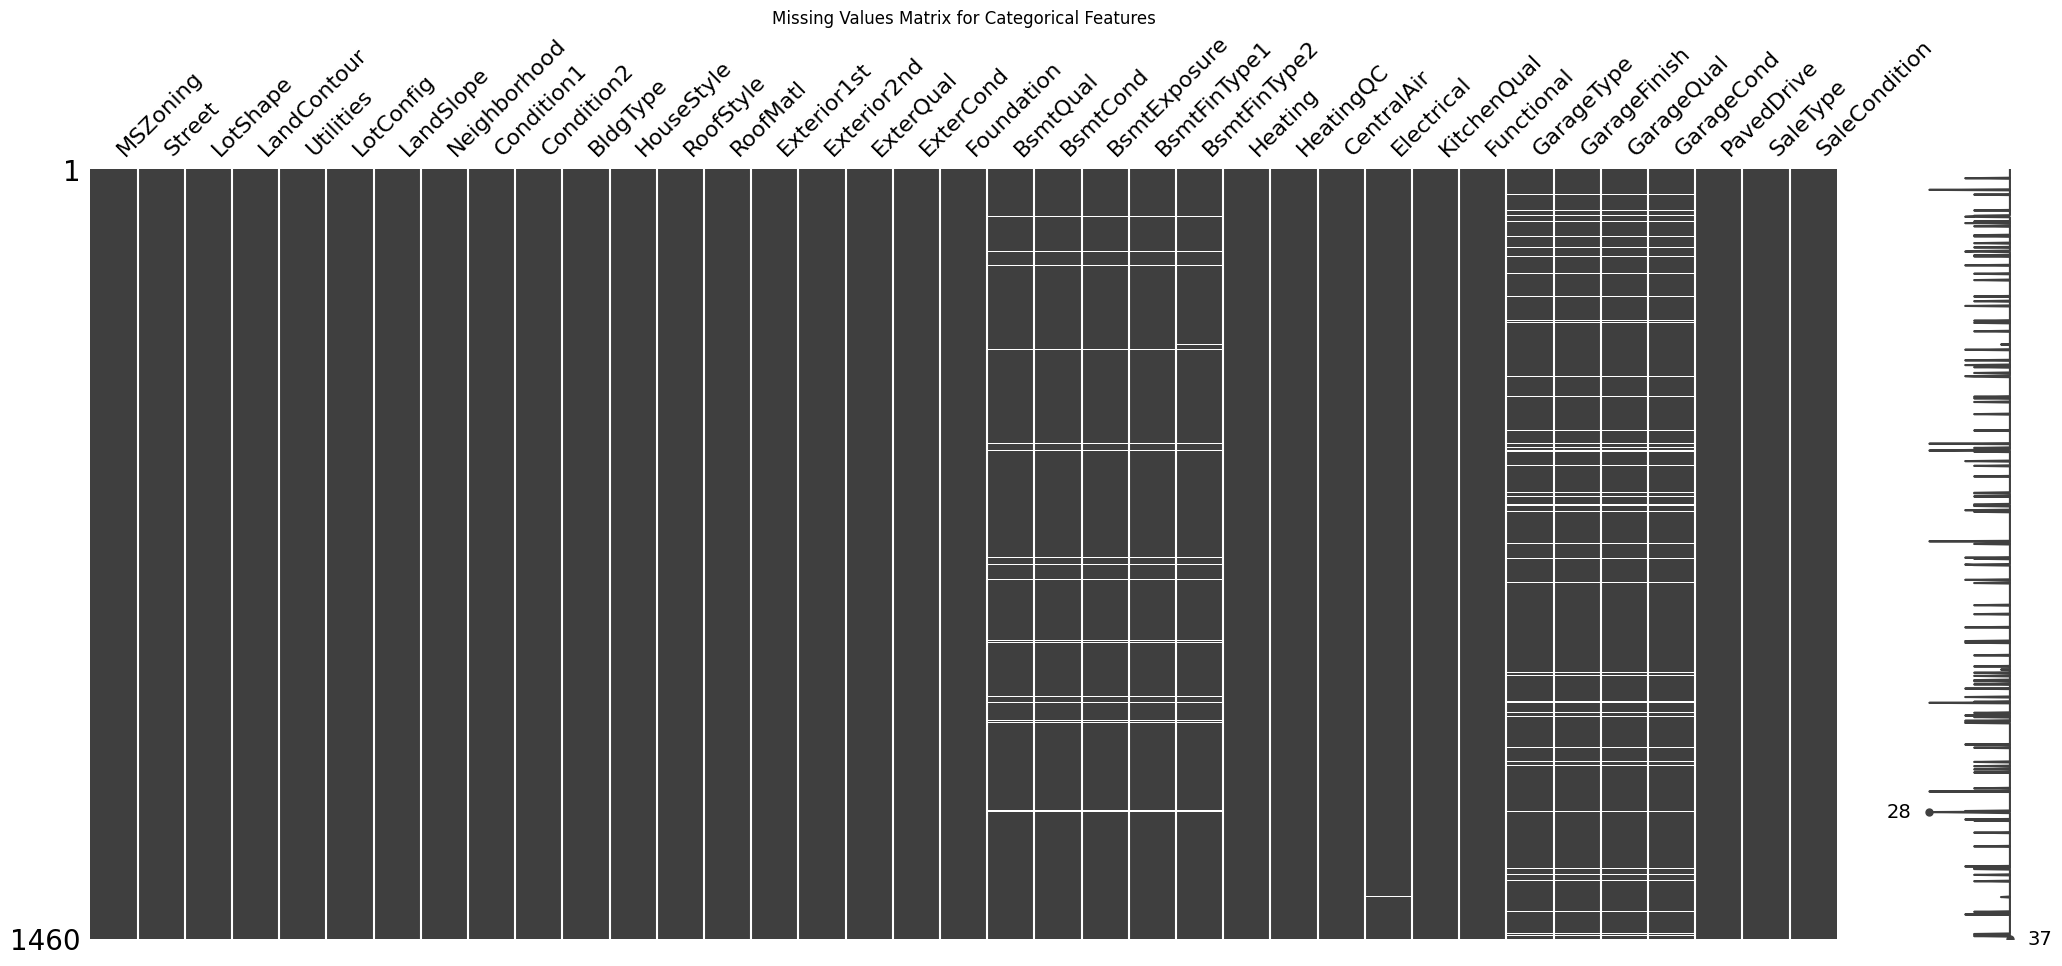

In [22]:
msno.matrix(categorical_features)
plt.title('Missing Values Matrix for Categorical Features')
plt.show()

💡 A very noticable pattern of missing values on the right, regarding the garage feature, **'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'**

Now that we have taken a very good and precies look at the mnso plot, what are the pattern of missing values?

When analyzing the plot, the examination of missing data patterns can help distinguish between **Missing Completely at Random (MCAR)**, **Missing at Random (MAR)**, and **Missing Not at Random (MNAR)** scenarios.

1- **MCAR** (Missing Completely at Random): If the missing values appear randomly across all variables, irrespective of the values of other variables, the data is considered MCAR. In the plot, missing values would seem scattered without any discernible pattern.

2- **MAR** (Missing at Random): In a MAR scenario, the likelihood of a value being missing depends on the observed values but not on the unobserved ones. The plot may reveal patterns of missingness associated with certain observed variables.

3- **MNAR** (Missing Not at Random): MNAR occurs when the missing values are related to the unobserved data itself. If certain values are systematically missing based on their own magnitude, the plot might indicate a non-random pattern.

In [23]:
missing_indicator = pd.isnull(train_data[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']]).astype(int)
observed_table = pd.crosstab(index=missing_indicator['GarageType'], 
                              columns=[missing_indicator['GarageFinish'], 
                                       missing_indicator['GarageQual'], 
                                       missing_indicator['GarageCond']],
                              margins=True)

chi2, p_value, _, _ = chi2_contingency(observed_table)

if p_value > 0.05:
    print("The missing data is not MNAR.")
else:
    print("The missing data is MNAR.")

The missing data is MNAR.


To conclude this mnso plot, we have 3 datatypes and 3 mnso plots.

* Int has no missing values.
* Float has a **MCAR** (Missing Completely at Random) pattern
* Categorical features are month missing at random and not missing at random. 

# Imputation of missing values

**There is no way to know what works best, based on your observations conduct tests and compare results.**

I decided to impute missing values of the float features with mean, categorical features with mode except for garage related features, since the missing values % is not high, i will test probalisitic imputation.

In [24]:
float_numeric_features=['LotFrontage','MasVnrArea','GarageYrBlt']
categorical_features=['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional'
       , 'PavedDrive',
       'SaleType', 'SaleCondition']

In [25]:
garage_features=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for feature in garage_features:
    probabilities = train_data[feature].value_counts(normalize=True)
    train_data[feature] = train_data[feature].fillna(np.random.choice(probabilities.index, p=probabilities.values))

train_data[float_numeric_features] = train_data[float_numeric_features].apply(lambda x: x.fillna(x.mean()), axis=0)

for feature in categorical_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature] = train_data[feature].fillna(mode_value)

In [26]:
for feature in garage_features:
    probabilities = test_data[feature].value_counts(normalize=True)
    test_data[feature] = test_data[feature].fillna(np.random.choice(probabilities.index, p=probabilities.values))

test_data[float_numeric_features] = test_data[float_numeric_features].fillna(test_data[float_numeric_features].mean())

for feature in categorical_features:
    mode_value = test_data[feature].mode()[0]
    test_data[feature] = test_data[feature].fillna(mode_value)

Now that we have observed the pattern and made our decision on the imputation techinques, let us take a final look at the mnso plot after imputation.

In [27]:
categorical_features = train_data.select_dtypes(include=['object'])
int_numeric_features = train_data.select_dtypes(include=['int64'])
float_numeric_features = train_data.select_dtypes(include=['float64'])

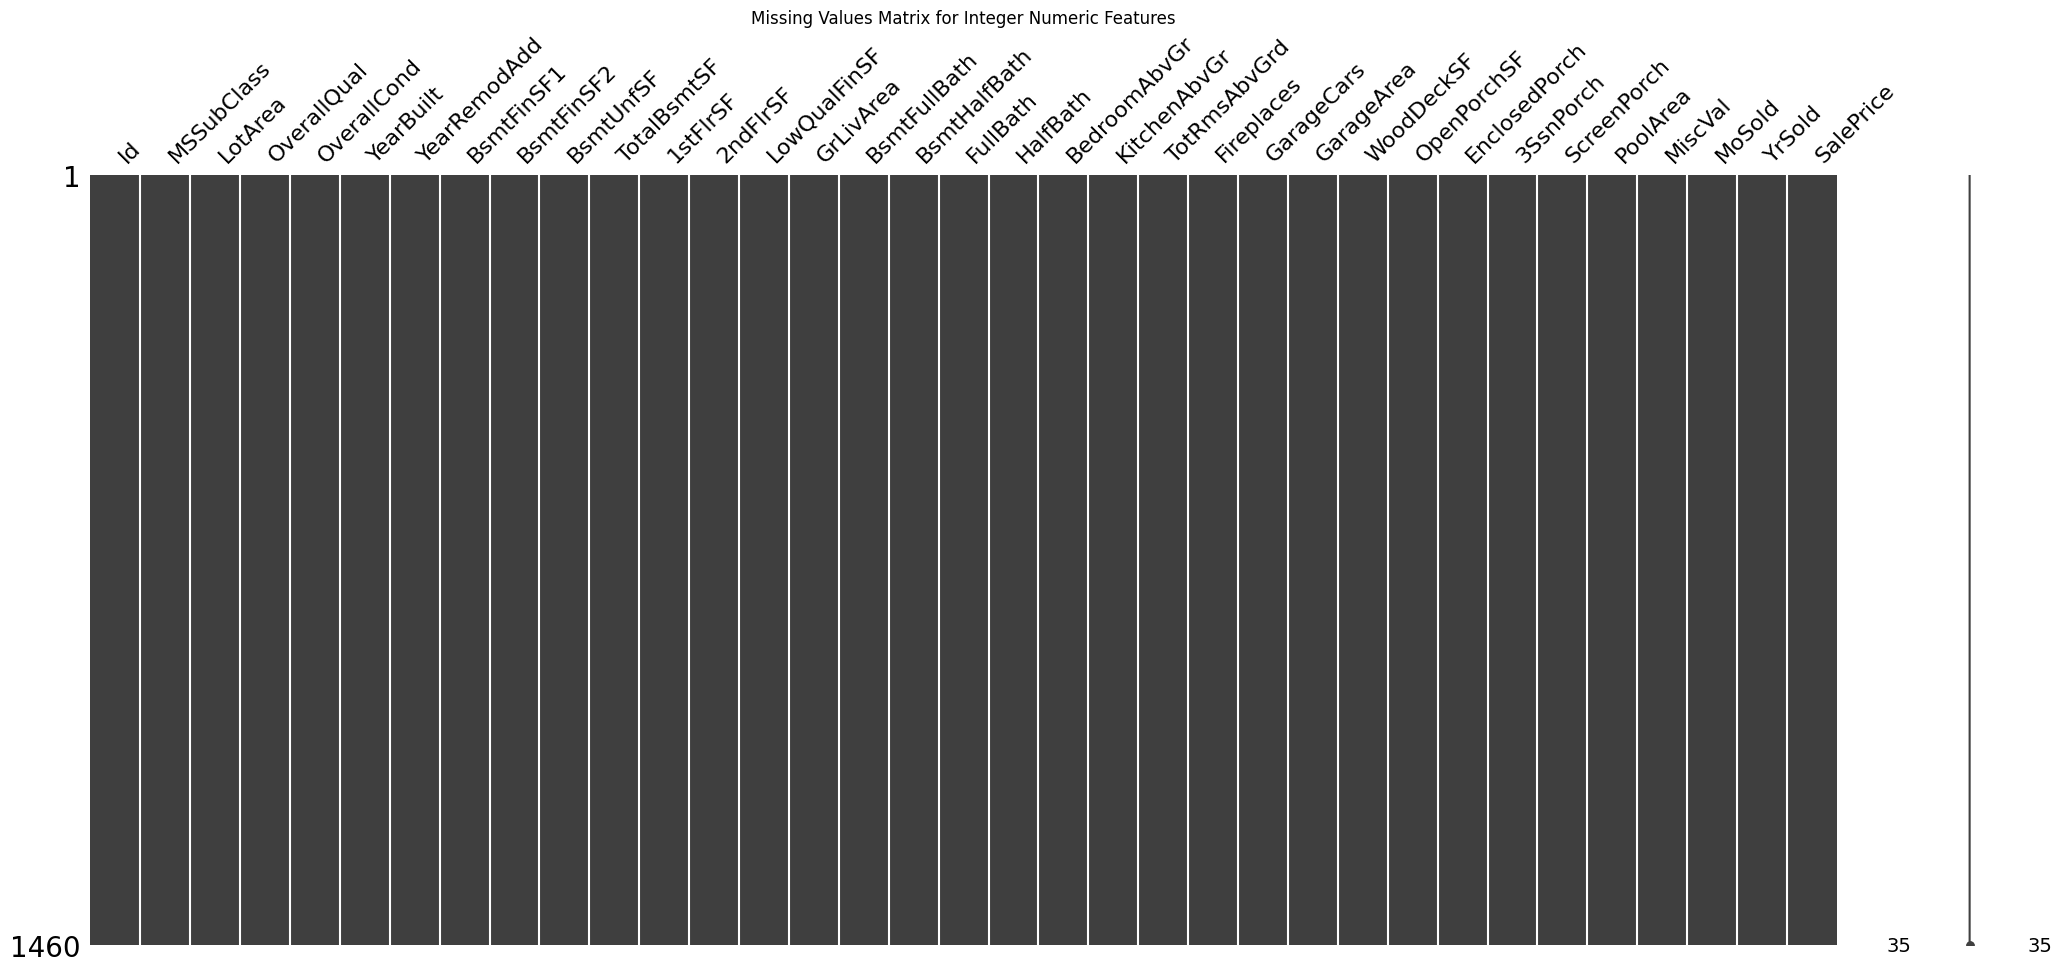

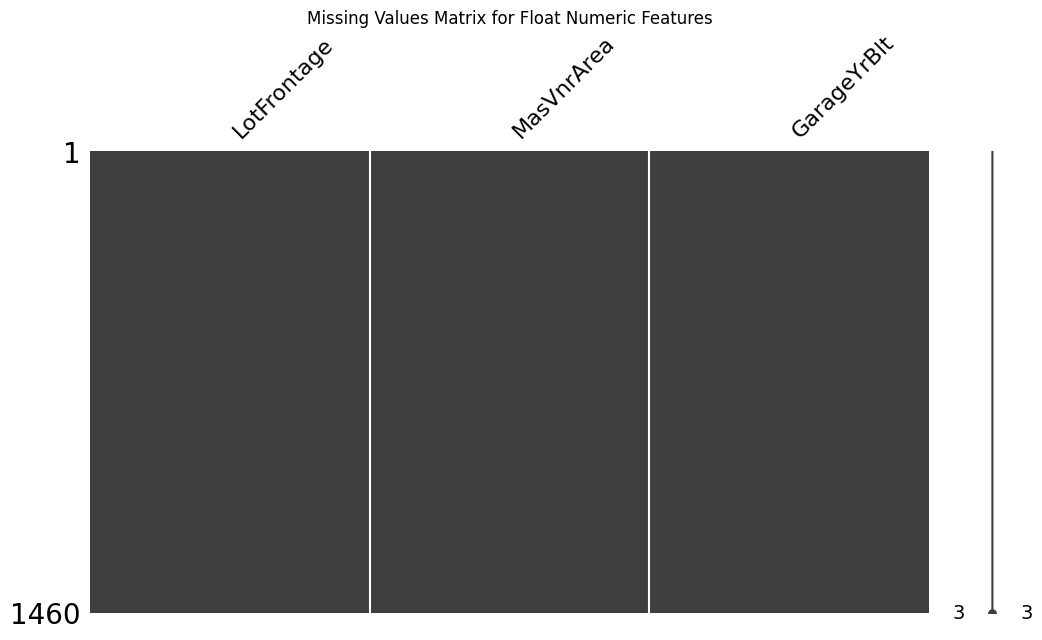

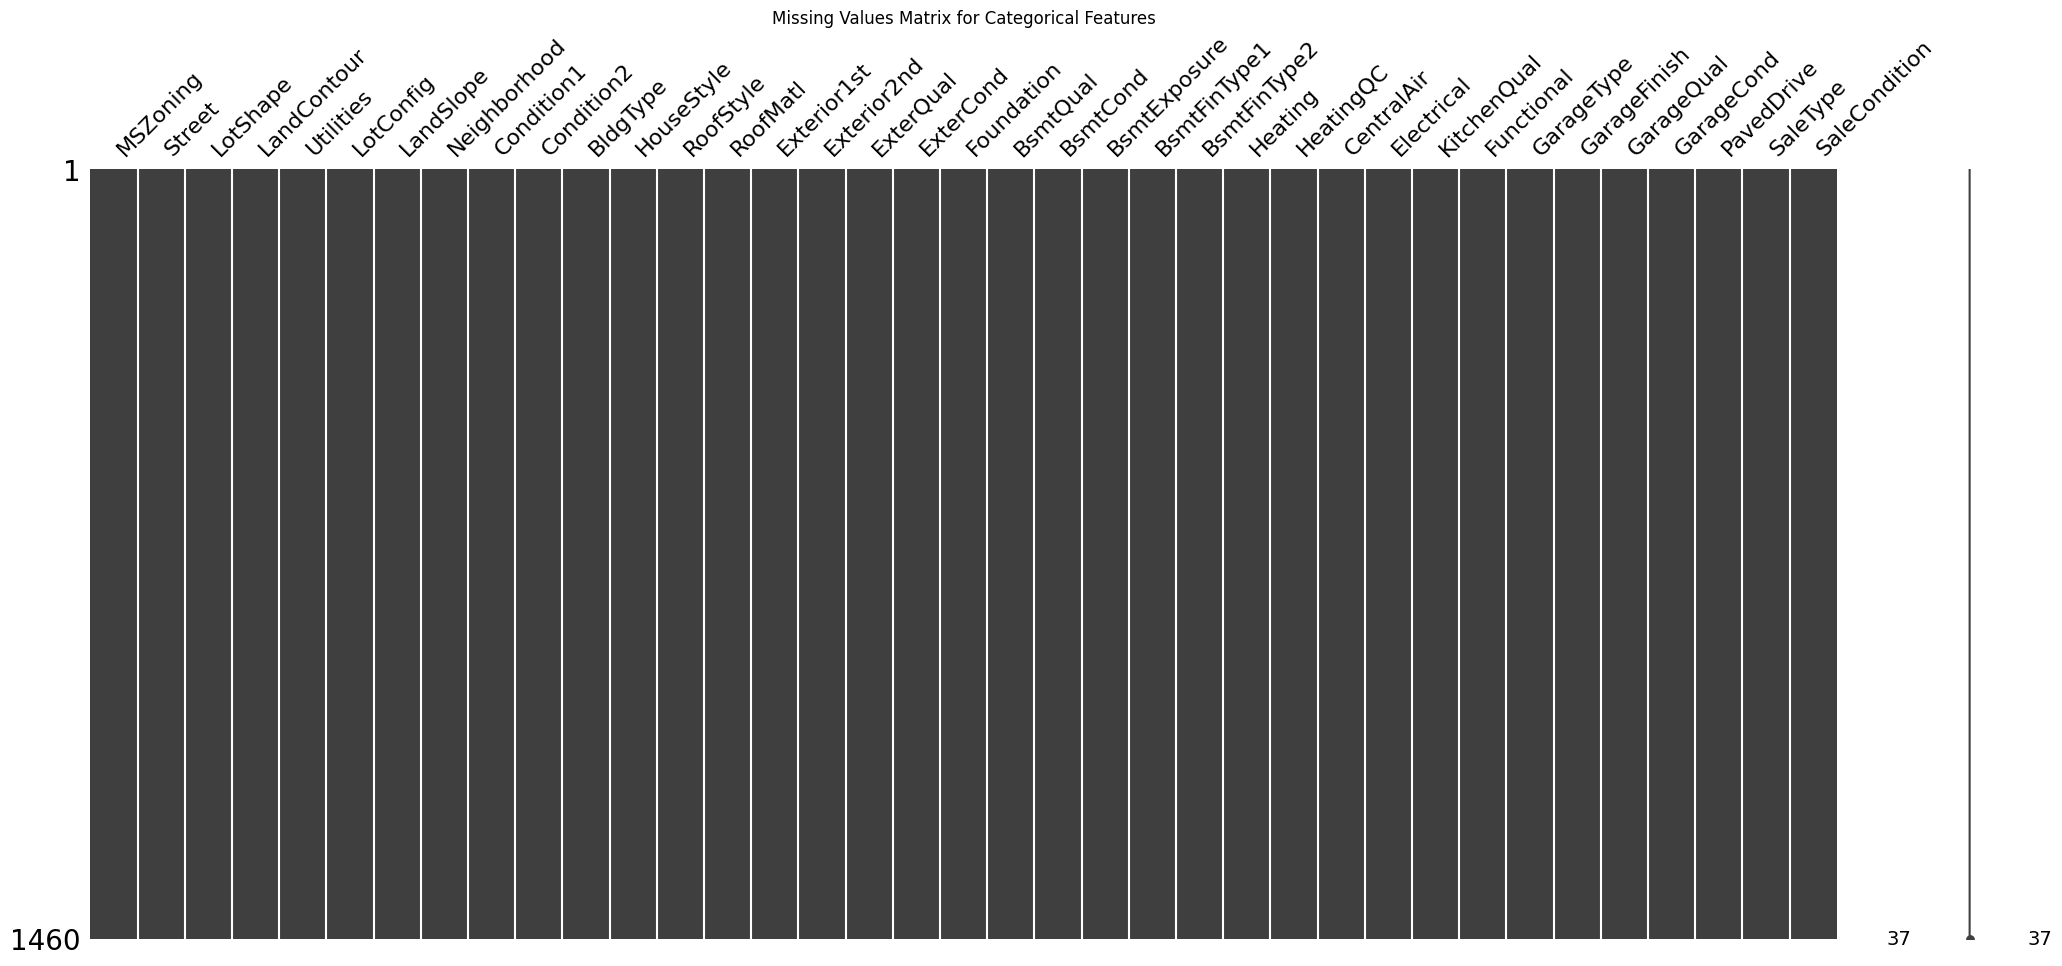

In [28]:
msno.matrix(int_numeric_features)
plt.title('Missing Values Matrix for Integer Numeric Features')
plt.show()

msno.matrix(float_numeric_features, figsize=(12, 6))
plt.title('Missing Values Matrix for Float Numeric Features')
plt.show()

msno.matrix(categorical_features)
plt.title('Missing Values Matrix for Categorical Features')
plt.show()

Very clean, Yosh! 🥳

# Train and Evaluation

In [29]:
x = train_data.drop(['SalePrice','Id'],axis = 1)
y = train_data['SalePrice']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [31]:
categorical_columns = x.select_dtypes(include=['object']).columns

numeric_features = x.columns.difference(categorical_columns)

numeric_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_columns)])

In [32]:

model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42))])

model.fit(x_train, y_train)

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test,predictions)

print(mae)

29308.414383561645


In [33]:
predict = model.predict(test_data)

# Submission

In [34]:
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': predict})
submission.to_csv('submission.csv',index = False)
submission.head()

,Id,SalePrice
0,1461,125000
1,1462,272000
2,1463,192000
3,1464,189000
4,1465,189000
